In [1]:
import bayesflow as bf
import numpy as np
from numba import jit

rng = np.random.default_rng()


2024-07-25 14:04:50.227277: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-25 14:04:50.252177: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 14:04:50.252201: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 14:04:50.252913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 14:04:50.257665: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Define hierarchical prior functions

def hierarchical_prior_fun():
    
    hyper_mu_v = rng.normal(3.00, 0.5)
    hyper_sigma_v = rng.uniform(0.01, 1.00)

    hyper_mu_a = rng.normal(3.00, 0.5)
    hyper_sigma_a = rng.uniform(0.01, 1.00)

    hyper_mu_t = rng.normal(0.5, .2)
    hyper_sigma_t = rng.uniform(0.01, .2)

    return np.concatenate([np.r_[hyper_mu_v, hyper_sigma_v, hyper_mu_a, hyper_sigma_a, hyper_mu_t, hyper_sigma_t]])


def local_prior_fun(hyper_theta=hierarchical_prior_fun, n_people = 10):
    v = rng.normal(hyper_theta[0], hyper_theta[1], size = n_people)
    a = rng.normal(hyper_theta[2], hyper_theta[3], size = n_people)
    t = rng.normal(hyper_theta[4], hyper_theta[5], size = n_people)


    return np.stack((v, a, t), axis=1)

prior = bf.simulation.TwoLevelPrior(hyper_prior_fun =  hierarchical_prior_fun, local_prior_fun = local_prior_fun)
prior(batch_size=3)

{'hyper_parameters': array([[2.19843821, 0.91640703, 2.75544173, 0.63448327, 0.49385858,
         0.08724096],
        [2.87390622, 0.5778726 , 3.17209858, 0.78350988, 0.4201603 ,
         0.18542671],
        [3.01125742, 0.11677557, 2.8550099 , 0.40694775, 0.40081297,
         0.10614653]]),
 'local_parameters': array([[[2.09492324, 1.98867283, 0.53863287],
         [2.47833443, 3.63970354, 0.60784429],
         [2.32002076, 2.35068144, 0.44171724],
         [3.61855928, 2.49763971, 0.48998096],
         [1.57387808, 2.75883325, 0.4214833 ],
         [2.09073313, 3.43736304, 0.43217233],
         [3.93580815, 2.43817251, 0.46697025],
         [2.73168688, 3.15043899, 0.35113437],
         [0.2958368 , 3.18509396, 0.50647832],
         [2.86296328, 1.7346399 , 0.57917331]],
 
        [[3.21448877, 3.1550909 , 0.36016835],
         [2.93053244, 2.66589139, 0.24625478],
         [2.2999244 , 3.33430105, 0.08970776],
         [1.68551181, 3.30969709, 0.76370335],
         [3.16354898, 5.

In [3]:
# Define hierarchical simulator function
@jit(nopython=True)

def diffusion_trial(v, a, ndt):
    """Simulates a trial from the diffusion model."""
    n_steps = 0.
    dt = 0.001
    max_steps = 10000
    x = a * 0.5
    # Simulate a single DM path
    while (x > 0 and x < a and n_steps < max_steps):

        # DDM equation
        x += v*dt + np.sqrt(dt) * np.random.normal()

        # Increment step
        n_steps += 1.0

    rt = n_steps * dt
    rt = rt + ndt 
    
    return rt

def minimal_hierarchical_simulator(theta, num_obs=200):

    num_participants = theta.shape[0]
    out = np.zeros((num_participants, num_obs))
    for j in range(num_participants): # loop over participants
        for k in range(num_obs): # loop over observations
            out[j, k] = diffusion_trial(theta[j,0],theta[j,1],theta[j,2])
    return out

In [6]:
simulator = bf.simulation.Simulator(simulator_fun=minimal_hierarchical_simulator)
model = bf.simulation.TwoLevelGenerativeModel(prior=prior, simulator=simulator, name="DDM Toy")

INFO:root:Performing 2 pilot runs with the DDM Toy model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 10, 3)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 10, 200)
INFO:root:Shape of hyper_prior_draws batch after 2 pilot simulations: (batch_size = 2, 6)
INFO:root:Shape of local_prior_draws batch after 2 pilot simulations: (batch_size = 2, 10, 3)
INFO:root:No shared_prior_draws provided.
INFO:root:No optional simulation batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional prior non-batchable context provided.


In [7]:
# Define minimal configurator

def configurator(forward_dict):
    """Configure the output of the GenerativeModel for a BayesFlow setup."""

    # Prepare placeholder dict
    out_dict = {}

    # Extract simulated response times
    out_dict["summary_conditions"] = np.expand_dims(forward_dict["sim_data"], axis=3)

    # Get data generating parameters
    out_dict["local_parameters"] = forward_dict["local_prior_draws"].astype(np.float32)

    # Get data generating parameters
    out_dict["hyper_parameters"] = forward_dict["hyper_prior_draws"].astype(np.float32)

    return out_dict

In [14]:
# Define networks

summary_net = bf.summary_networks.HierarchicalNetwork([
    bf.networks.DeepSet(summary_dim=6), 
    bf.networks.DeepSet(summary_dim=60)
])

local_inference_net = bf.networks.InvertibleNetwork(
    num_params=3,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="local_ddm_inference"
)

hyper_inference_net = bf.networks.InvertibleNetwork(
    num_params=6,
    coupling_settings={"dense_args": dict(kernel_regularizer=None), "dropout": False},
    name="hyper_ddm_inference"
)

local_amortizer = bf.amortizers.AmortizedPosterior(local_inference_net, name="local_amortizer")
hyper_amortizer = bf.amortizers.AmortizedPosterior(hyper_inference_net, name="hyper_amortizer")
twolevel_amortizer = bf.amortizers.TwoLevelAmortizedPosterior(summary_net = summary_net,
                                                            local_amortizer = local_amortizer,
                                                            global_amortizer = hyper_amortizer)

In [ ]:
# Train

trainer = bf.trainers.Trainer(generative_model=model, amortizer=twolevel_amortizer, configurator=configurator)
history = trainer.train_online(epochs=30, iterations_per_epoch=1000, batch_size=16)


INFO:root:Performing a consistency check with provided components...
INFO:root:Done.


Training epoch 1:   0%|          | 0/1000 [00:00<?, ?it/s]

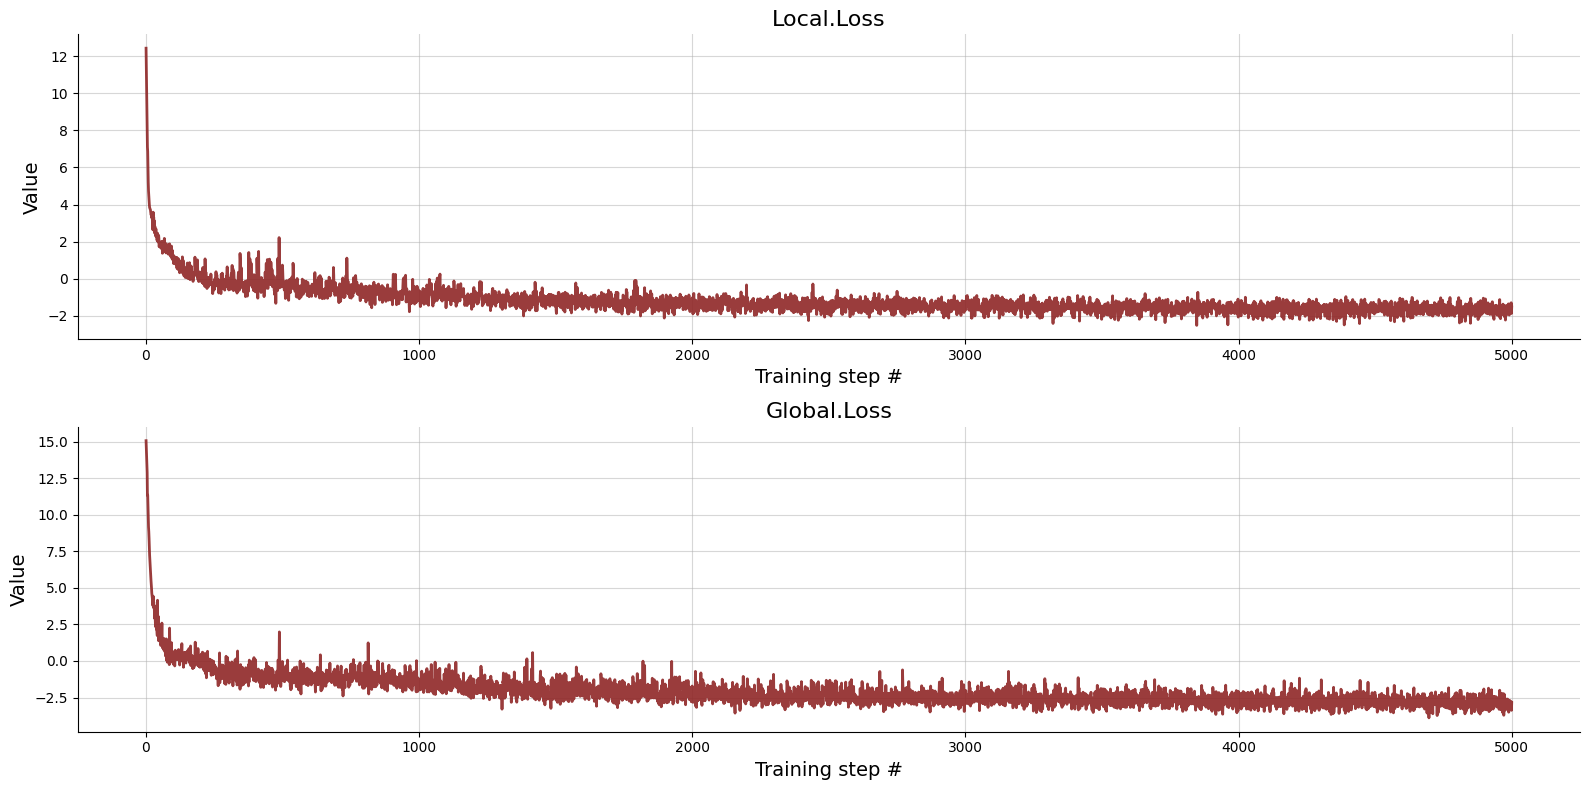

In [280]:
# Plot losses

f = bf.diagnostics.plot_losses(history)

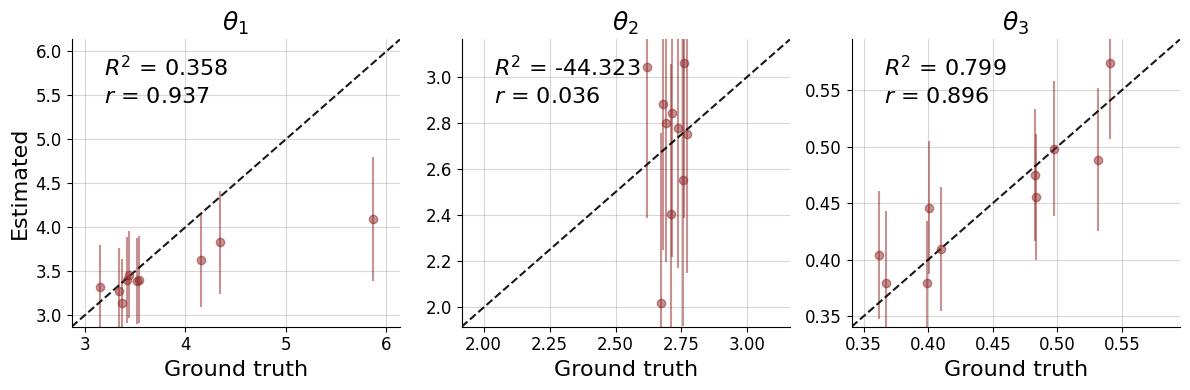

In [283]:
# Plot recovery of local parameters

validation_sims = configurator(model(batch_size=1))
prior_samples = np.squeeze(validation_sims["local_parameters"], axis=0)
post_samples = twolevel_amortizer.sample(validation_sims, n_samples=10000)

f = bf.diagnostics.plot_recovery(
    post_samples["local_samples"],
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)

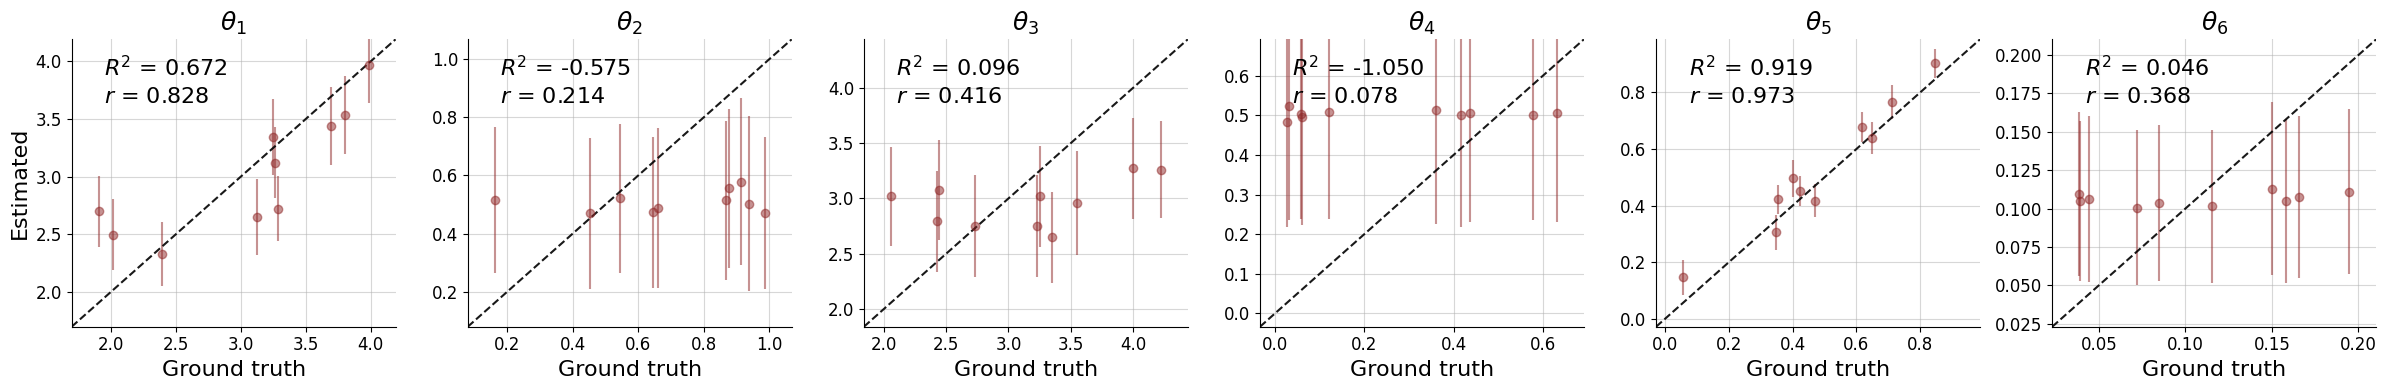

In [284]:
# Plot recovery of hyper parameters
batch_size = 10

prior_samples = validation_sims["hyper_parameters"]
post_samples = np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=10000)["global_samples"], axis=0)

for batch in range(batch_size-1):
    validation_sims = configurator(model(1))
    prior_samples = np.concatenate((prior_samples, validation_sims["hyper_parameters"]), axis=0)
    post_samples = np.concatenate((post_samples,
                                   np.expand_dims(twolevel_amortizer.sample(validation_sims, n_samples=10000)["global_samples"], axis=0)), axis=0)

f = bf.diagnostics.plot_recovery(
    post_samples,
    prior_samples, point_agg=np.mean, uncertainty_agg=np.std
)